# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

In [10]:

import pandas as pd
import logging

import sys
sys.path.append('../../src/utils')

# Utilities
from housing_prices_column_definition import Column


## 1. Exploratory Data Analysis (EDA)

### 1.1 Loading the initial Dataset.

In [11]:
# Load dataset from CSV format
rawDataPath = '../../datasets/raw/hyderabad_house_price_original.csv'
datasetPath = '../../datasets/processed/housing_prices/hyderabad_house_price_original.parquet'

# try:
#     raw_data = pd.read_csv(rawDataPath, dtype=Column.get_dtypes_dict())
#     raw_data.to_parquet(datasetPath)
# except (FileNotFoundError, ValueError) as e:
#     logging.exception(f"Error trying to load the dataset '{rawDataPath}'. Cause: {e}")


# raw_data.info()
Column.show_expected_columns_details()


Column: AC
  - Description: A flag indicating if air conditioning is included.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: Area
  - Description: The area of the property in square feet.
  - Expected Type: int64
  - Expected Format: {:,.0f}

Column: ATM
  - Description: A flag for the availability of a nearby ATM.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: BED
  - Description: A flag indicating if a bed is included.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: Cafeteria
  - Description: A flag for the availability of a cafeteria.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: CarParking
  - Description: A flag for the availability of car parking.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: Children'splayarea
  - Description: A flag for the availability of a children's play area.
  - Expected Type: int64
  - Expected Format: {:.0f}

Column: ClubHouse
  - Description: A flag for the availability of a c

**Initial Observation:**

- The dataset has been loaded successfully. 
- The data types in the dataset match the expected data types.
- It contains 2518 samples (rows) and 40 dimensions (columns).
- There are no columns with missing values.
- The Location column is object and the others are numeric type. 
- Most columns represent whether the house includes a specific amenity.
- Other columns refer to the area and number of bedrooms in the houses.
- The Price column will be our target.

### 1.2 Descriptive Statistics for ALL Columns.

In [12]:
dataset = pd.read_parquet(datasetPath)
    
all_stats = dataset.describe(include='all')
styled_all_stats = all_stats.style.format(Column.get_format_dict(), na_rep="-")

display(styled_all_stats)

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,ATM,ClubHouse,School,24X7Security,PowerBackup,CarParking,StaffQuarter,Cafeteria,MultipurposeRoom,Hospital,WashingMachine,Gasconnection,AC,Wifi,Children'splayarea,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
count,"$ 2,434.0000","2,434",2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434
unique,-,-,239,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
top,-,-,Kukatpally,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
freq,-,-,163,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
mean,$ 15.8760,7,-,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
std,$ 0.6227,0,-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
min,$ 14.5087,6,-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,$ 15.3758,7,-,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,$ 15.8696,7,-,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
75%,$ 16.2043,8,-,3,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0


| Feature | Detailed Observation | Implication & Next Steps |
| :--- | :--- | :--- |
| **Price** | The range is vast (₹2M to ₹16.5 Cr). The mean (**₹9.8M**) is significantly higher than the median (**₹7.7M**), and the standard deviation is almost as large as the mean. | The distribution is **highly right-skewed** due to outliers. A **logarithmic transformation** (`np.log1p`) will likely be necessary for better model performance. |
| **Area** | Ranges from 500 to 9,400 sq ft. There is a clear positive trend with `Price`, but the variance in `Price` increases as `Area` gets larger. | `Area` is a **strong, primary predictor**. The increasing variance suggests the relationship might not be perfectly linear. Feature scaling (like `StandardScaler`) will be necessary. |
| **Location** | A **high-cardinality categorical feature** with 243 unique values. `Kukatpally` is the most frequent. Median prices vary drastically between locations. | This is a critical feature, but its high number of unique values requires a careful **encoding strategy** (e.g., target encoding or grouping) to avoid making the dataset too wide. |
| **No. of Bedrooms**| A discrete feature from 1 to 8, centered around 3. While median price increases with more bedrooms, there is a **significant price overlap** between categories. | This overlap implies that `No. of Bedrooms` alone isn't enough to determine price; its interaction with `Area` and `Location` is key. It can be used directly as a numerical feature. |
| **Resale** | A **binary feature** (0 or 1) indicating if a property is new (0) or a resale (1). | This clearly segments the market. We need to analyze if there is a significant price difference between new and resale properties and check if the classes are imbalanced. |
| **Amenities** | Multiple amenity columns (e.g., `MaintenanceStaff`, `Gymnasium`, `SwimmingPool`) are expected to be binary but contain the value **`9`**. | The value `9` likely represents **missing or unknown data**. This is a critical **data quality issue** that must be addressed during data cleaning, for example, by replacing them with the mode (likely `0`). |

### 1.3 Checking missing values.

In [13]:
print("Total Missing values:", dataset.isnull().sum().sum())
dataset.isnull().sum()

Total Missing values: 0


Price                  0
Area                   0
Location               0
No. of Bedrooms        0
Resale                 0
MaintenanceStaff       0
Gymnasium              0
SwimmingPool           0
LandscapedGardens      0
JoggingTrack           0
RainWaterHarvesting    0
IndoorGames            0
ShoppingMall           0
Intercom               0
SportsFacility         0
ATM                    0
ClubHouse              0
School                 0
24X7Security           0
PowerBackup            0
CarParking             0
StaffQuarter           0
Cafeteria              0
MultipurposeRoom       0
Hospital               0
WashingMachine         0
Gasconnection          0
AC                     0
Wifi                   0
Children'splayarea     0
LiftAvailable          0
BED                    0
VaastuCompliant        0
Microwave              0
GolfCourse             0
TV                     0
DiningTable            0
Sofa                   0
Wardrobe               0
Refrigerator           0


### 1.4 Checking Outliers.

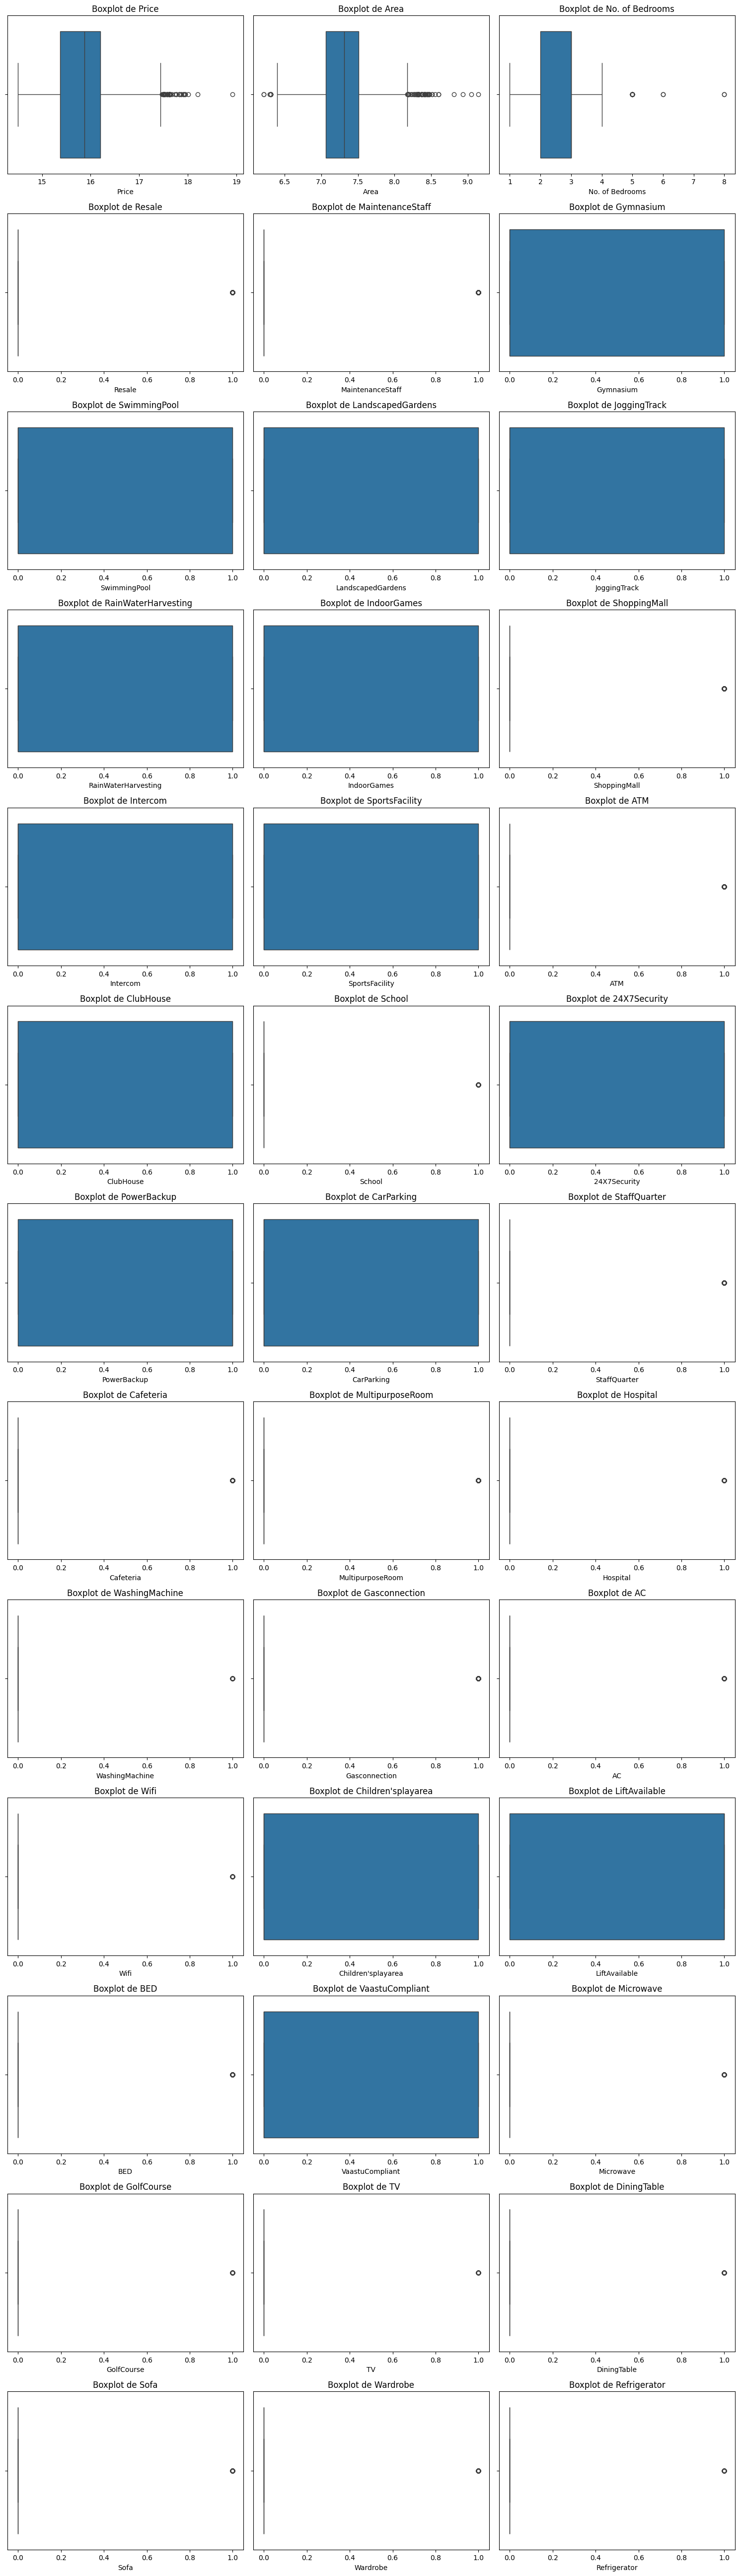

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


numeric_cols = dataset.select_dtypes(include=["int64", "float64"]).columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()


for i, col in enumerate(numeric_cols):
    sns.boxplot(x=dataset[col], ax=axes[i])
    
    axes[i].set_title(f"Boxplot de {col}")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

**Initial Observation:**

| # | Observation                                                                                                                                                                                            | Recommended Next Steps                                                                                                                                                                                                                                                          |
|:-:|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | **Address Skewness:** The `Price` and `Area` variables are heavily right-skewed. This can negatively impact the performance of many machine learning models that assume a normal distribution.         | **Apply Log Transformation:** Use a function like `np.log1p` on these columns to normalize their distributions. After transforming, generate the boxplots again to confirm that the skewness has been reduced.                                                                |
| 2 | **Investigate Outliers:** All numerical features show a significant number of outliers (the points outside the whiskers). These extreme values could disproportionately influence model training.           | **Develop an Outlier Strategy:** First, determine if the outliers are data entry errors or valid, extreme values. Based on this, decide whether to cap them (e.g., using winsorization), remove them, or keep them. Document the chosen approach and your reasoning. |
| 3 | **Invalid Amenity Values:** The amenity features (e.g., `MaintenanceStaff`, `Gymnasium`) are expected to be binary (0 or 1), but the plots show values greater than 1. This indicates a data quality issue. | **Clean and Standardize Data:** 1. Investigate the unique values in these columns (e.g., `df['MaintenanceStaff'].unique()`). 2. Define a rule to correct them (e.g., map all non-zero values to 1). 3. Apply the correction and then re-visualize with a `countplot` to confirm the data is now binary. |

### 1.5 Distribution of data by column

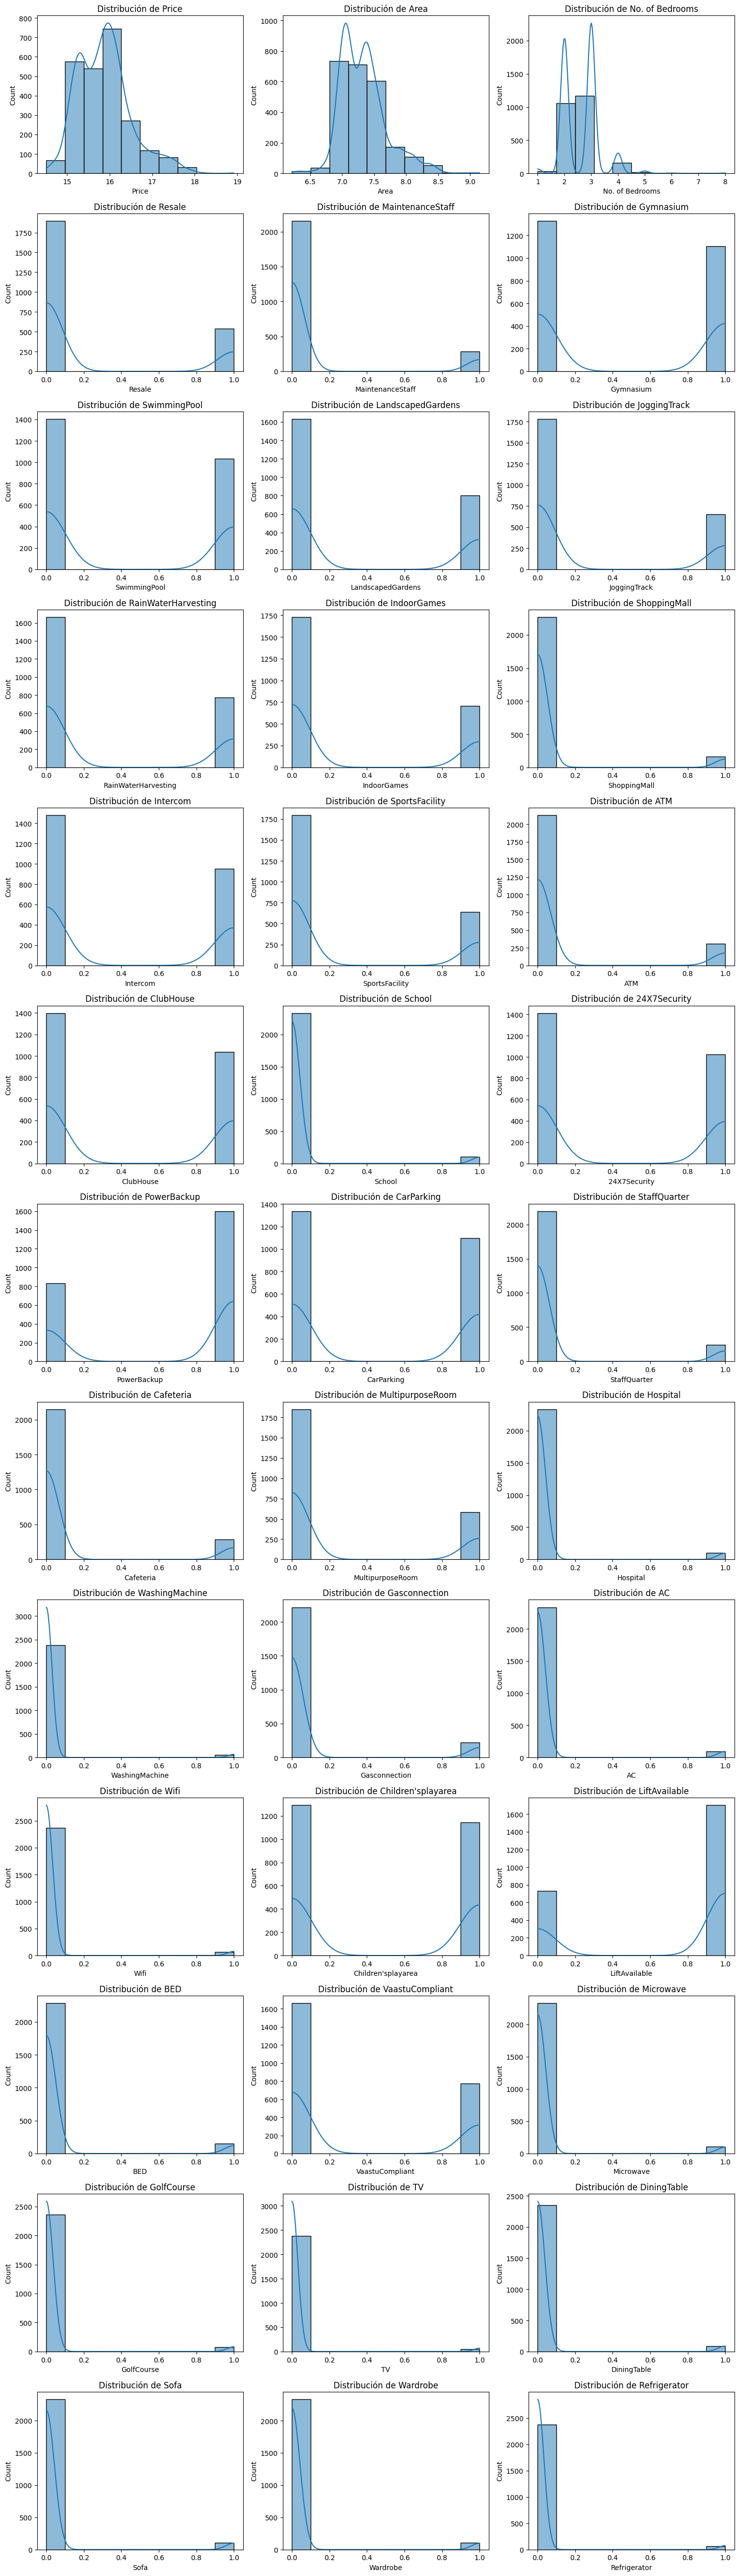

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select the numeric columns
numeric_cols = dataset.select_dtypes(include=["int64","float64"]).columns

# Layout de subplots columns and rows
n_cols = 3  
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # lo convertimos a 1D para iterar fácil

# Create histogram in each subplot
for i, col in enumerate(numeric_cols):
    sns.histplot(data=dataset, x=col, bins=10, ax=axes[i], kde=True)
    axes[i].set_title(f"Distribución de {col}")

# Remove empty axles if there are any left over
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.6 Correlation Matrix

Correlation is a statistical measure that indicates how strongly and in what direction two variables are related.

- If one variable increases and the other also increases, we say there is a positive correlation.
- If one variable increases and the other decreases, we speak of a negative correlation.
- If there is no clear pattern, the correlation is close to 0 (no linear relationship).

                        Price      Area  No. of Bedrooms    Resale  \
Price                1.000000  0.894670         0.721387  0.188685   
Area                 0.894670  1.000000         0.832536  0.153118   
No. of Bedrooms      0.721387  0.832536         1.000000  0.143768   
Resale               0.188685  0.153118         0.143768  1.000000   
MaintenanceStaff     0.190709  0.224188         0.194256  0.025715   
Gymnasium            0.417505  0.356698         0.251620 -0.079763   
SwimmingPool         0.451000  0.387685         0.282202 -0.066704   
LandscapedGardens    0.386495  0.324981         0.254163 -0.008042   
JoggingTrack         0.391124  0.375262         0.303814 -0.017468   
RainWaterHarvesting  0.330687  0.314141         0.233713 -0.039848   
IndoorGames          0.386551  0.332797         0.255062 -0.057435   
ShoppingMall         0.077861  0.066819         0.042980 -0.014758   
Intercom             0.297617  0.257430         0.193740 -0.118082   
SportsFacility      

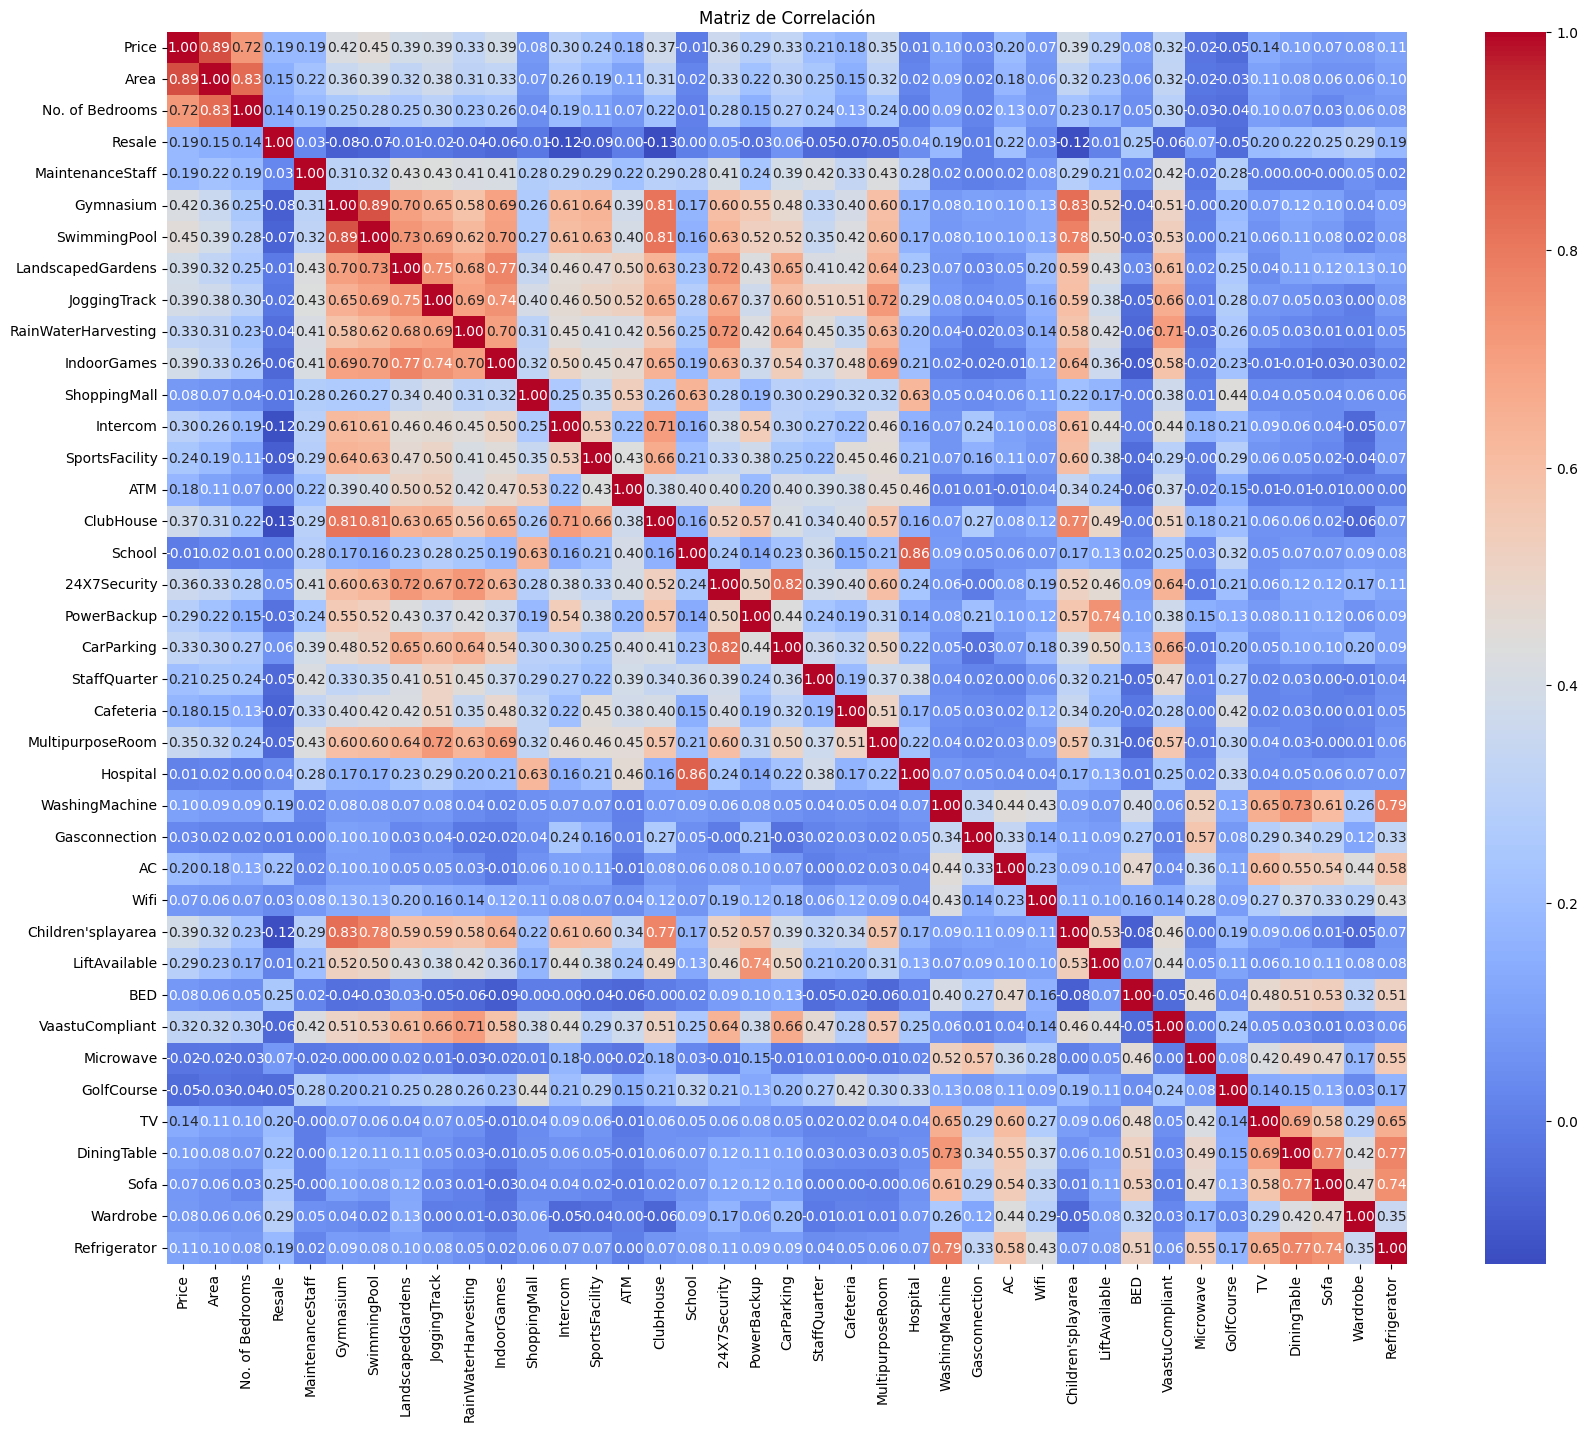

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

df = dataset.copy()
numeric_ds = df.select_dtypes(include=["int64", "float64"])

corr = numeric_ds.corr()
print(corr)

# HitMap
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### 1.7 Variance Inflation Factor

The Variance Inflation Factor (VIF) is a measure that helps us identify multicollinearity in a regression model. In simple terms, it tells us how much the variance of an estimated regression coefficient is inflated because a predictor variable is correlated with other predictor variables in the model.

High multicollinearity is a problem because it can make our model's coefficients unstable and difficult to interpret.

- VIF = 1 → Non-collinearity.
- VIF between 1 and 5 → Acceptable.
- VIF > 10 → Serious multicollinearity problem.

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

df = dataset.copy()    


X = df.select_dtypes(include=["int64", "float64"]).drop(columns=[Column.PRICE.name, Column.LOCATION.name], errors="ignore")
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]

print(vif_data)

                feature       VIF
0                  Area  3.780893
1       No. of Bedrooms  3.462948
2                Resale  1.270636
3      MaintenanceStaff  1.596005
4             Gymnasium  7.046584
5          SwimmingPool  6.314127
6     LandscapedGardens  4.224839
7          JoggingTrack  4.137525
8   RainWaterHarvesting  3.554771
9           IndoorGames  4.031001
10         ShoppingMall  2.545315
11             Intercom  2.485607
12       SportsFacility  2.650662
13                  ATM  2.352544
14            ClubHouse  5.816215
15               School  4.231146
16         24X7Security  4.924652
17          PowerBackup  2.994950
18           CarParking  4.067241
19         StaffQuarter  1.808544
20            Cafeteria  1.959864
21     MultipurposeRoom  2.754019
22             Hospital  4.420629
23       WashingMachine  3.404078
24        Gasconnection  1.739183
25                   AC  2.178534
26                 Wifi  1.412934
27   Children'splayarea  4.320509
28        Lift

### 1.8 Checking categorical data

In [18]:
dataset[Column.LOCATION.name].value_counts()

Location
Kukatpally                           163
Kondapur                             142
Manikonda                            112
Nizampet                             104
Hitech City                           81
                                    ... 
Old Alwal                              1
Secunderabad Railway Station Road      1
Balapur                                1
Hastinapur                             1
chandrayangutta                        1
Name: count, Length: 239, dtype: int64